# Sentiment Analysis

## Dependencies

In [1]:
import os
import re

import numpy as np
import pandas as pd

import seaborn as sns

from google.oauth2 import service_account
from google.cloud import bigquery

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
from tensorflow.keras import Model
from keras.optimizer_v2.adagrad import Adagrad
from keras.layers import Embedding, Dense, concatenate, Input, \
    GlobalMaxPooling1D, Dropout
from keras.layers.convolutional import Conv1D
from keras.losses import BinaryCrossentropy
from keras.preprocessing.text import tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences

from gensim.models import Word2Vec

## Loading Data

In [2]:
key_path = '../airflow/credentials/future-data-track-1-sapporo.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

bigquery_client = bigquery.Client(
    project='future-data-track-1',
    credentials=credentials
)

In [3]:
query = """
SELECT * FROM `future-data-track-1.sapporo_mart.sampled_sentiment_analysis`;
"""

query_job = bigquery_client.query(query)
df = query_job.to_dataframe()

In [4]:
df.head()

,review,rating,sentiment
0,Ok siap,1,0
1,Banyak toko yg beralamat dijakarta eh ternyata...,1,0
2,"Payah payaaaaaaaaaahh!!! Udah terang"" dapet ba...",1,0
3,"Toko yg gajelas, gue pesen baju motif army dik...",1,0
4,Ngentod,1,0


In [5]:
df.isna().sum()

review       0
rating       0
sentiment    0
dtype: int64

In [6]:
df = df.dropna(axis=0)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264000 entries, 0 to 263999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review     264000 non-null  object
 1   rating     264000 non-null  int64 
 2   sentiment  264000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.1+ MB


### Preprocessing

In [8]:
def preprocessing_text(texts):
    texts = re.sub(r'<.*?>', '', texts)
    texts = re.sub(r'[^a-zA-Z]', ' ', texts)
    texts = list(filter(lambda x: x, [x.lower() for x in texts.split(" ")]))

    return texts

In [9]:
df['review_cleaned'] = df['review'].apply(lambda x : preprocessing_text(x))

In [10]:
df.head()

,review,rating,sentiment,review_cleaned
0,Ok siap,1,0,"[ok, siap]"
1,Banyak toko yg beralamat dijakarta eh ternyata...,1,0,"[banyak, toko, yg, beralamat, dijakarta, eh, t..."
2,"Payah payaaaaaaaaaahh!!! Udah terang"" dapet ba...",1,0,"[payah, payaaaaaaaaaahh, udah, terang, dapet, ..."
3,"Toko yg gajelas, gue pesen baju motif army dik...",1,0,"[toko, yg, gajelas, gue, pesen, baju, motif, a..."
4,Ngentod,1,0,[ngentod]


In [11]:
tokenizer_file = open('Tokenizer/tokens_30k.json', 'r')

tokenizer = tokenizer_from_json(tokenizer_file.read())

tokenizer_file.close()

In [12]:
seq = tokenizer.texts_to_sequences(df['review_cleaned'])
X = pad_sequences(seq, maxlen=120, padding='post')

print(f'X_shape: {X.shape}, X_min: {np.min(X)}, X_max: {np.max(X)}')

X_shape: (264000, 120), X_min: 0, X_max: 29999


In [13]:
y = df['sentiment'].map({0:0, 2:1})

### Train-test split

In [14]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(168960, 120) (42240, 120) (52800, 120) (168960,) (42240,) (52800,)


## Prepare Embedding

In [15]:
EMBEDDING_FILEPATH = 'Embedding/w2v_emoji_sw_v4.w2v'

In [16]:
embedding = Word2Vec.load(EMBEDDING_FILEPATH)

In [17]:
words = len(embedding.wv)
print('Vocabulary size: %d' % words)

Vocabulary size: 90294


In [18]:
def get_weight_matrix(embedding: Word2Vec, vocab):
    vocab_size = len(vocab) + 1

    weight_matrix = np.zeros((vocab_size, 100))

    for word, i in vocab.items():
        try:
            weight_matrix[i] = embedding.wv.get_vector(word)
        except:
            continue
    
    return weight_matrix

In [19]:
embedding_vectors = get_weight_matrix(embedding, tokenizer.word_index)

In [20]:
vocab_size = len(tokenizer.word_index) + 1
max_length = X.shape[1]

## Create Model Layers

In [21]:
embedding = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_vectors], input_length=max_length, trainable=True)

sequence_input = Input(shape=(max_length,))
l_embedding = embedding(sequence_input)

convs = []

filter_sizes = [2,3,4,5,6]

for filter_size in filter_sizes:
    l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu',
                    padding='same', strides=2)(l_embedding)
    
    l_pool = GlobalMaxPooling1D()(l_conv)
    convs.append(l_pool)

l_merge = concatenate(convs, axis=1)

x = Dropout(0.1)(l_merge)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

preds = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 120, 100)     4536200     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 60, 128)      25728       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 60, 128)      38528       embedding[0][0]                  
______________________________________________________________________________________________

## Training Model

In [22]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
optimizer = Adagrad(learning_rate=0.01)
model.compile(loss=BinaryCrossentropy(), optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=15, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

Epoch 1/15
5280/5280 [==============================] - 472s 89ms/step - loss: 0.4110 - accuracy: 0.8314 - val_loss: 0.3732 - val_accuracy: 0.8471
Epoch 2/15
5280/5280 [==============================] - 456s 86ms/step - loss: 0.3684 - accuracy: 0.8499 - val_loss: 0.3613 - val_accuracy: 0.8534
Epoch 3/15
5280/5280 [==============================] - 450s 85ms/step - loss: 0.3536 - accuracy: 0.8574 - val_loss: 0.3561 - val_accuracy: 0.8560
Epoch 4/15
5280/5280 [==============================] - 434s 82ms/step - loss: 0.3434 - accuracy: 0.8612 - val_loss: 0.3554 - val_accuracy: 0.8564
Epoch 5/15
5280/5280 [==============================] - 435s 82ms/step - loss: 0.3337 - accuracy: 0.8651 - val_loss: 0.3549 - val_accuracy: 0.8568
Epoch 6/15
5280/5280 [==============================] - 437s 83ms/step - loss: 0.3250 - accuracy: 0.8684 - val_loss: 0.3584 - val_accuracy: 0.8579
Epoch 7/15
5280/5280 [==============================] - 443s 84ms/step - loss: 0.3167 - accuracy: 0.8717 - val_loss: 0

<AxesSubplot:>

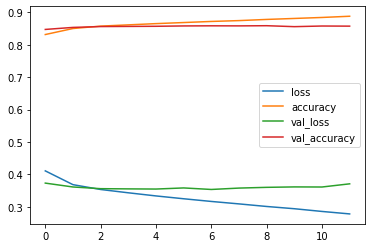

In [23]:
pd.DataFrame(history.history).plot()

              precision    recall  f1-score   support

           0       0.86      0.85      0.85     26251
           1       0.86      0.86      0.86     26549

    accuracy                           0.86     52800
   macro avg       0.86      0.86      0.86     52800
weighted avg       0.86      0.86      0.86     52800



<AxesSubplot:>

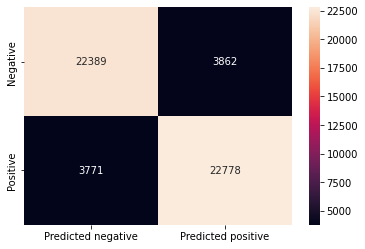

In [24]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

## Serializing Model

In [25]:
MODEL_NAME = 'CNN_Sentiment'
MODEL_VERSION = (5, 0)
MODEL_DIRNAME = '_'.join([MODEL_NAME, '.'.join(map(str, MODEL_VERSION))])
MODEL_DIRNAME = os.path.join('Sentiment Analysis', 'CNN', MODEL_DIRNAME)

In [26]:
model.save(MODEL_DIRNAME)

INFO:tensorflow:Assets written to: CNN_Sentiment_5.0/assets
